In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [7]:
def make_regret(payoffs, oracles):
    """
    Generate the cummulative regret over time.
    Parameters:
    -----------
        payoffs: an array of T payoffs (for T number of trials)
        oracles: an array of best values for T trials (oracles)
    Returns:
        Array of the cumulative sum over time (of size T = number of trials)
    """
    
    return np.cumsum(oracles - payoffs)

In [69]:
def generate_distribution(mean, var):
    return np.random.normal(mean, var)

def get_choice_probability(n_Arms, mean_vector=None):
    if mean_vector is None:
        return np.random.dirichlet(np.ones(n_Arms))
    else:
        return np.random.dirichlet(mean_vector)

def generate_sequence(sequence_length, nArms, mean_vector=None):
    data_dict = {}
    for seq_num in range(sequence_length):
        data_dict[seq_num] = {}
        
        arm_prob = get_choice_probability(nArms, mean_vector)
        arm_choice = np.random.choice([i for i in range(nArms)], 1, p=arm_prob)[0]
        
        data_dict[seq_num]['sequence_number'] = seq_num
        data_dict[seq_num]['arm_choice'] = arm_choice
    
    return pd.DataFrame(data_dict).T

def generate_features(df):
    df = df.copy()
    df['feature_1'] = df['arm_choice'].shift(1)
    df['feature_2'] = df['arm_choice'].shift(2)
    df['feature_3'] = df['arm_choice'].shift(3)
    df['feature_4'] = df['arm_choice'].shift(4)
    df['feature_5'] = df['arm_choice'].shift(5)
    df['feature_6'] = df['arm_choice'].shift(6)
    
    return df.dropna()
    

In [70]:
def generate_reward(chosen_arm, optimal_action):
    if chosen_arm == optimal_action:
        return 1
    return 0

In [71]:
def lin_ucb(alpha, X, n_arms, generate_reward, optimal_action):
    """
    Simulate the LINUCB algorithm using the generated data X.
    Parameters:
    -----------
        alpha: this is the ::math:`\alpha = \sqrt{ln(2/\sigma)/2}`
        X: is the observed data (contexts for all arms at every trial)
        generate_reward: a function used to generate the reward for an arm given a context and a theta
        true_theta: the true theta used to generate the oracles and compare the losses (regrets)
    """
    
    # Data storages
    n_trials, n_features = X.shape
    arm_choice = np.empty(n_trials) # used to store agent's choices for each trial
    r_payoffs = np.empty(n_trials) # used to store the payoff for each trial (the payoff for the selected arm based on the true_theta)
    
    theta = np.empty(shape=(n_trials, n_arms, n_features)) # used to store the predicted theta over each trial
    p = np.empty(shape=(n_trials, n_arms)) # used to store predictions for reward of each arm for each trial
    
    # Lin UCB Objects
    A = np.array([np.diag(np.ones(shape=n_features)) for _ in np.arange(n_arms)]) # A is the matrix defined as :math:A_a = D_a^TD_a + I_d, and for the initialization it is I_d and will be updated after every trial
    b = np.array([np.zeros(shape=n_features) for _ in np.arange(n_arms)]) # b is the matrix defined as response vectors (reward for each feature for each arm at each trial, initialized to zero for all features of all arms at every trial)
    
    # The algorithm
    for t in range(n_trials):
        # compute the estimates (theta) and prediction (p) for all arms
        for a in range(n_arms):
            inv_A = np.linalg.inv(A[a])
            theta[t, a] = inv_A.dot(b[a]) # estimate theta as from this formula :math:`\hat{\theta}_a = A_a^{-1}b_a`
            p[t, a] = theta[t, a].dot(X[t]) + alpha * np.sqrt(X[t].dot(inv_A).dot(X[t])) # predictions is the expected mean + the confidence upper bound
        
        # choosing the best arms
        chosen_arm = np.argmax(p[t])
        x_chosen_arm = X[t]
        r_payoffs[t] = generate_reward(chosen_arm, optimal_action[t]) # This payoff is for the predicted chosen arm, and but the payoff is based on theoretical theta (true theta)
        arm_choice[t] = chosen_arm
        
        # Update intermediate objects (A and b)
        A[chosen_arm] += np.outer(x_chosen_arm, x_chosen_arm.T)
        b[chosen_arm] += r_payoffs[t]*x_chosen_arm # update the b values for each features corresponding to the pay off and the features of the chosen_arm
    
    return dict(theta=theta, p=p, arm_choice=arm_choice, r_payoffs = r_payoffs)

In [72]:
feature_vector = ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6']

In [73]:
def plot_regrets(results, oracles):
    [plt.plot(make_regret(payoffs=x['r_payoffs'], oracles=oracles), label="alpha: " + str(alpha)) for (alpha, x) in results.items()]


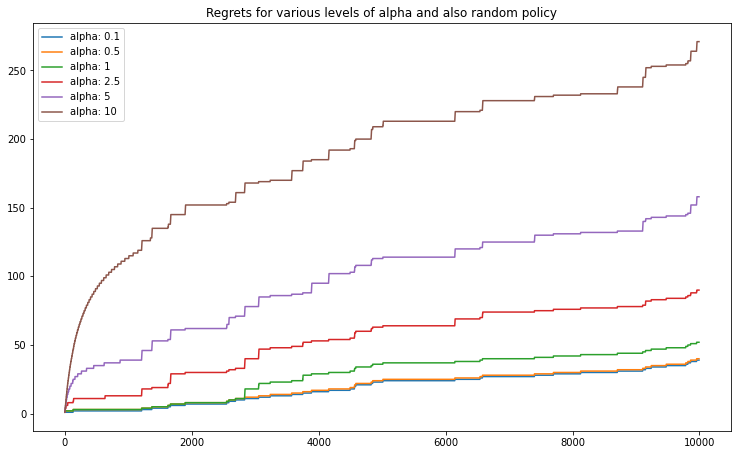

In [80]:
df = generate_sequence(10000, 3, np.array([0.1, 50.1, 0.1]))
final_df = generate_features(df)
alphas = [0.1, 0.5, 1, 2.5, 5, 10]
results_dict = {
    alpha: lin_ucb(alpha=alpha, 
                   X = final_df[feature_vector].to_numpy(),
                   n_arms = 3,
                   generate_reward=generate_reward, 
                   optimal_action = final_df['arm_choice'].to_numpy()) 
    for alpha in alphas
}

plt.figure(figsize=(12.5, 7.5))
plot_regrets(results_dict, np.ones(final_df.shape[0]))
# plot also the random one
plt.legend()
plt.title("Regrets for various levels of alpha and also random policy")
plt.show()


In [83]:
final_df

,sequence_number,arm_choice,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6
6,6,1,1.0,1.0,1.0,1.0,1.0,1.0
7,7,1,1.0,1.0,1.0,1.0,1.0,1.0
8,8,1,1.0,1.0,1.0,1.0,1.0,1.0
9,9,1,1.0,1.0,1.0,1.0,1.0,1.0
10,10,1,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...
9995,9995,1,1.0,1.0,1.0,1.0,1.0,1.0
9996,9996,1,1.0,1.0,1.0,1.0,1.0,1.0
9997,9997,1,1.0,1.0,1.0,1.0,1.0,1.0
9998,9998,1,1.0,1.0,1.0,1.0,1.0,1.0
